### This code illustrates how to compute the orientational correlation function for a single $CO_{2}$ molecule in a given trajectory

### Prerequisite:
* MSD_calculation.ipynb

### Package Required:
* numpy
* mdtraj
* matplotlib
* scipy

#### Note: If you don't have the packages listed above installed, then you can type in the following commands in the terminal
* conda install numpy
* conda install -c conda-forge mdtraj
* conda install matplotlib
* conda install scipy

### File Required:
* A trajectory file (.h5)

* Note: Here, I use a trajectory that contains only one CO2 molecule as an example (~/pikachu/homes/zhuo/haverford/code_example/BMIM_PF6_CO2_system_eq_step4.h5), but this code can also be used for systems with multiple CO2 molecules.

### Background:

* Orientation correlation function (OCF)

The orientation correlation function describes how the rotational motion of a molecule is correlated at different times throughout a simulation, and it also provides information on the time required for a molecule to decorrelate from its initial orientation. The orientation correlation function can be calculated via the following expression: 

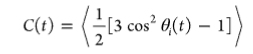, 

where the angle $\theta$ is defined as follows: 

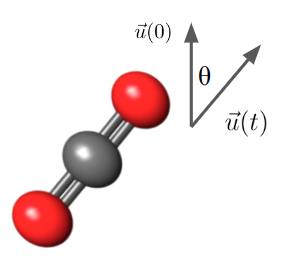

* Reference: [https://pubs.acs.org/doi/epdf/10.1021/jp304528d]

### The Actual Code:

1. Import the required package

In [1]:
import numpy as np
import mdtraj as md

2. Load the trajectory file 

In [2]:
traj = md.load_hdf5('BMIM_PF6_CO2_system_eq_step4.h5')
traj

<mdtraj.Trajectory with 10000 frames, 12550 atoms, 513 residues, and unitcells at 0x7f0181413080>

3. Extract some basic information from the trajectory

In [3]:
box_sizes = traj.unitcell_lengths[0]
box_sizes

array([4.4480777, 4.4480777, 4.4480777], dtype=float32)

In [4]:
n_frames = traj.n_frames
n_frames

10000

In [5]:
n_atoms = traj.n_atoms
n_atoms

12550

In [6]:
timestep = traj.timestep/1000 # convert ps into ns here
timestep

0.01

4. Extract the xyz coordinates for the given atoms (e.g. C and O). You will need define the initial orientation axis for the OCF calculation; here, the C=O bond is chosen to represent the inital orientation.  

In [7]:
carbon = traj.topology.select('name == C') # here, we extract the atom_index for the carbon atom in the snapshot 
carbon

array([0])

In [8]:
oxygen = traj.topology.select('name == O1') # here, we extract the atom_index for the oxygen atom in the snapshot 
oxygen

array([1])

In [9]:
xyz_carbon = traj.xyz[:,carbon,:] # traj.xyz[frame_id,atom_index,xyz_coordinates]
# Here, we extract all the xyz coordinates for the carbon atoms throughout all the frames 
xyz_carbon

array([[[0.5326969, 0.5994113, 2.7604756]],

       [[0.5366426, 0.6764617, 2.7344258]],

       [[0.6820233, 0.5732599, 2.8127644]],

       ...,

       [[1.5890062, 3.9633927, 3.207243 ]],

       [[1.5668223, 3.9849327, 3.149382 ]],

       [[1.6794393, 4.078516 , 3.2362943]]], dtype=float32)

In [10]:
xyz_oxygen = traj.xyz[:,oxygen,:]
xyz_oxygen

array([[[0.4512439 , 0.6476219 , 2.7166533 ]],

       [[0.63321745, 0.63804066, 2.7405827 ]],

       [[0.7427778 , 0.55556893, 2.9098735 ]],

       ...,

       [[1.6158041 , 4.0844626 , 3.212176  ]],

       [[1.5446558 , 4.0973015 , 3.1699421 ]],

       [[1.6982757 , 3.9888752 , 3.1581645 ]]], dtype=float32)

5. Set up the time separation, $\tau$. 

In [11]:
taus = np.linspace(0,(n_frames-1)*timestep,n_frames) # The minimum tau value is set to be the same as the timestep
taus

array([0.000e+00, 1.000e-02, 2.000e-02, ..., 9.997e+01, 9.998e+01,
       9.999e+01])

6. Define periodic boundary conditions. E.g. For a 3x3 square, the vector from (1,1) to (3,3), or (2,2), is identical to (-1,-1) when PBC is considered. NOTE: Under PBC, the angle $\theta$ may change to $\pi$ - $\theta$; however, since we are using $\theta$ into the OCF function to calculate $cos^{2}\theta$, the result won't change since $\pi$ is a period for $cos^{2}\theta$.

In [12]:
def vector_pbc(x0,x1,Box):
    """
    calculate vector with periodic boundary condition

    x0 -- initial position
    x1 -- finial position
    Box -- box size
    everything is in 1D, but can be used to calculate multiple dimensions as well
    """

    delta = x1 - x0
    delta= np.where(np.abs(delta) > 0.5 * Box, np.where(delta > 0, np.abs(delta)-Box,Box-np.abs(delta)), delta)
    return delta

7. Define the OCF function. 

In [13]:
def P2(x):
    """
    calculate 2nd Legendre polynomial
    """
    return 0.5*(3*x**2 - 1)

8. Now, we are about to calculate the OCF. Note: a$\cdot$b = |a||b|cos$\theta$

In [26]:
CC_OCF = np.zeros(len(taus))
for i in range(0,len(taus)):
    vector1 = vector_pbc(xyz_carbon[np.arange(0,n_frames-i),:,:],xyz_oxygen[np.arange(0,n_frames-i),:,:],box_sizes) # Compute the C=O vector at time t1
    vector2 = vector_pbc(xyz_carbon[np.arange(i,n_frames),:,:],xyz_oxygen[np.arange(i,n_frames),:,:],box_sizes)  # Compute the C=O vector at time t2   
    vector1_norm = vector1/np.expand_dims(np.linalg.norm(vector1, axis=-1), 2) # Normalize the vector as a unit vector
    vector2_norm = vector2/np.expand_dims(np.linalg.norm(vector2, axis=-1), 2)
    cosine_theta = np.sum(vector1_norm*vector2_norm, axis=-1) # Calculate cosine_theta
    CC_OCF[i] = np.mean(P2(cosine_theta))

9. Save the data to a .txt file

In [15]:
np.savetxt('BMIM_PF6_CO2_system_eq_step4_ocf.txt',np.c_[taus, CC_OCF],fmt ='%.6f',delimiter =',',header='taus[ns],c2(t)')

10. Plot the data 

In [16]:
import matplotlib.pyplot as plt

Text(0.5, 0, '$\\tau$ (ns)')

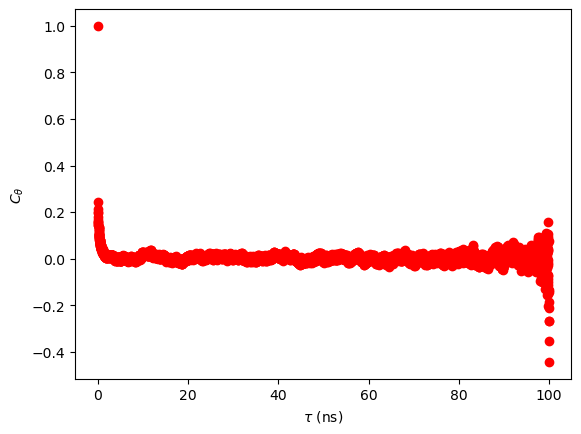

In [17]:
plt.scatter(taus,CC_OCF,color='red',marker='o')
plt.ylabel(r'$C_{\theta}$')
plt.xlabel(r'$\tau$ (ns)')

11. Data fitting

The curve above can be fitted into an exponential function

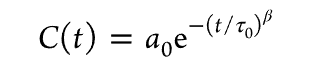


In [18]:
import scipy.optimize as spo

In [19]:
def exp(t, a, tau, b):
    return a*np.exp(-(t/tau)**b)

/tmp/ipykernel_5247/1000941570.py:2: RuntimeWarning: invalid value encountered in power
  return a*np.exp(-(t/tau)**b)


(-0.1, 0.6)

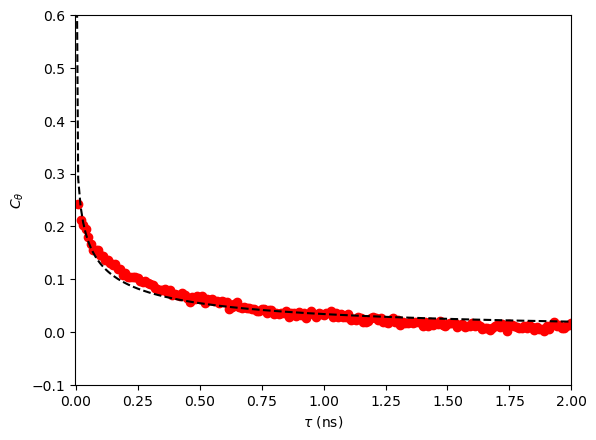

In [20]:
fit = spo.curve_fit(exp, taus, CC_OCF)
plt.plot(taus, exp(taus, *fit[0]), 'k--',label='fit')
plt.scatter(taus,CC_OCF,color='red',marker='o')
plt.ylabel(r'$C_{\theta}$')
plt.xlabel(r'$\tau$ (ns)')
plt.xlim(-0.001, 2)
plt.ylim(-0.1,0.6)

Extract the beta term or stretching parameter from the fitting function with s.d.

In [21]:
print(fit[0][2], r"$\pm$", np.sqrt(np.diag(fit[1]))[2])

0.21854768964538704 $\pm$ 0.0042293911966477


This term correlates to the system's viscosity, which describes the dynamic of molecules within the system. As the stretching parameter increases, the system will have faster dynamics.